#### Preparación del input:

>> Objetivo: (t, 32, 32, 1)

In [1]:
from funciones import * 

carpeta  ="../Datos/raw_10casos/" #Carpeta que contiene la info

variables=["wspd_wdir10_0", "wspd_wdir10_1", "HGT", "XLAT","XLONG","XLAND", "PBLH", "PSFC", "TH2","times"] #también son los nombres de las subcarpetas

casos    =['2015_10_21', 
           '2016_04_30', '2016_06_15', '2016_12_13', 
           '2017_07_28', 
           '2018_03_21', '2018_06_09', '2018_06_23', '2018_07_04',
           '2019_08_23'] #fecha de los casos

In [2]:
%%time 

stack = extraccion_rutas(variables, casos, carpeta)

variable wspd_wdir10_0 lista
variable wspd_wdir10_1 lista
variable HGT lista
variable XLAT lista
variable XLONG lista
variable XLAND lista
variable PBLH lista
variable PSFC lista
variable TH2 lista
variable times lista
CPU times: user 5min 8s, sys: 12.4 s, total: 5min 20s
Wall time: 5min 28s


In [3]:
def reshape_tensor(stack, var=variables, caso=casos, input=False):

    bloque= tf.zeros([1, 32, 32, 1], dtype=tf.float32)
    for caso in casos:
        valores= stack[var][caso][119:] if not input else stack[var][caso][:119] 
        valores_reshape= tf.reshape(valores,(valores.shape[0] * valores.shape[1], valores.shape[2], valores.shape[3],1))
        bloque=tf.concat( [bloque, valores_reshape], axis=0)
    bloque=bloque[1:] #eliminamos el valor inicial 
    print(bloque.shape)
    
    return bloque

In [4]:
vientos_target=reshape_tensor(var=variables[0],stack=stack, input=False)
vientos_input =reshape_tensor(var=variables[0],stack=stack, input=True) 
orog_input    =reshape_tensor(var=variables[2],stack=stack, input=True)
xlat_input    =reshape_tensor(var=variables[3],stack=stack, input=True)
xlong_input   =reshape_tensor(var=variables[4],stack=stack, input=True)
xland_input   =reshape_tensor(var=variables[5],stack=stack, input=True)
pblh_input    =reshape_tensor(var=variables[6],stack=stack, input=True)
psfc_input    =reshape_tensor(var=variables[7],stack=stack, input=True)
th2_input     =reshape_tensor(var=variables[8],stack=stack, input=True)

(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)
(185640, 32, 32, 1)


In [11]:
tensor_old= tf.squeeze( stack[variables[0]][casos[0]][0] ) #eliminar las dimensiones de tamaño 1
tensor_new= tf.squeeze( vientos_input[:156] ) #lo mismo que antes
print("dimensiones del tensor original: ", tensor_old.shape)
print("dimensiones del tensor original: ", tensor_new.shape)

comparacion= tf.reduce_all(tf.equal(tensor_old, tensor_new)) #comparacion valor por valor
if comparacion: 
    print("Los tensores son iguales")
else:
    print("Los tensores son diferentes")

dimensiones del tensor original:  (156, 32, 32)
dimensiones del tensor original:  (156, 32, 32)
Los tensores son iguales


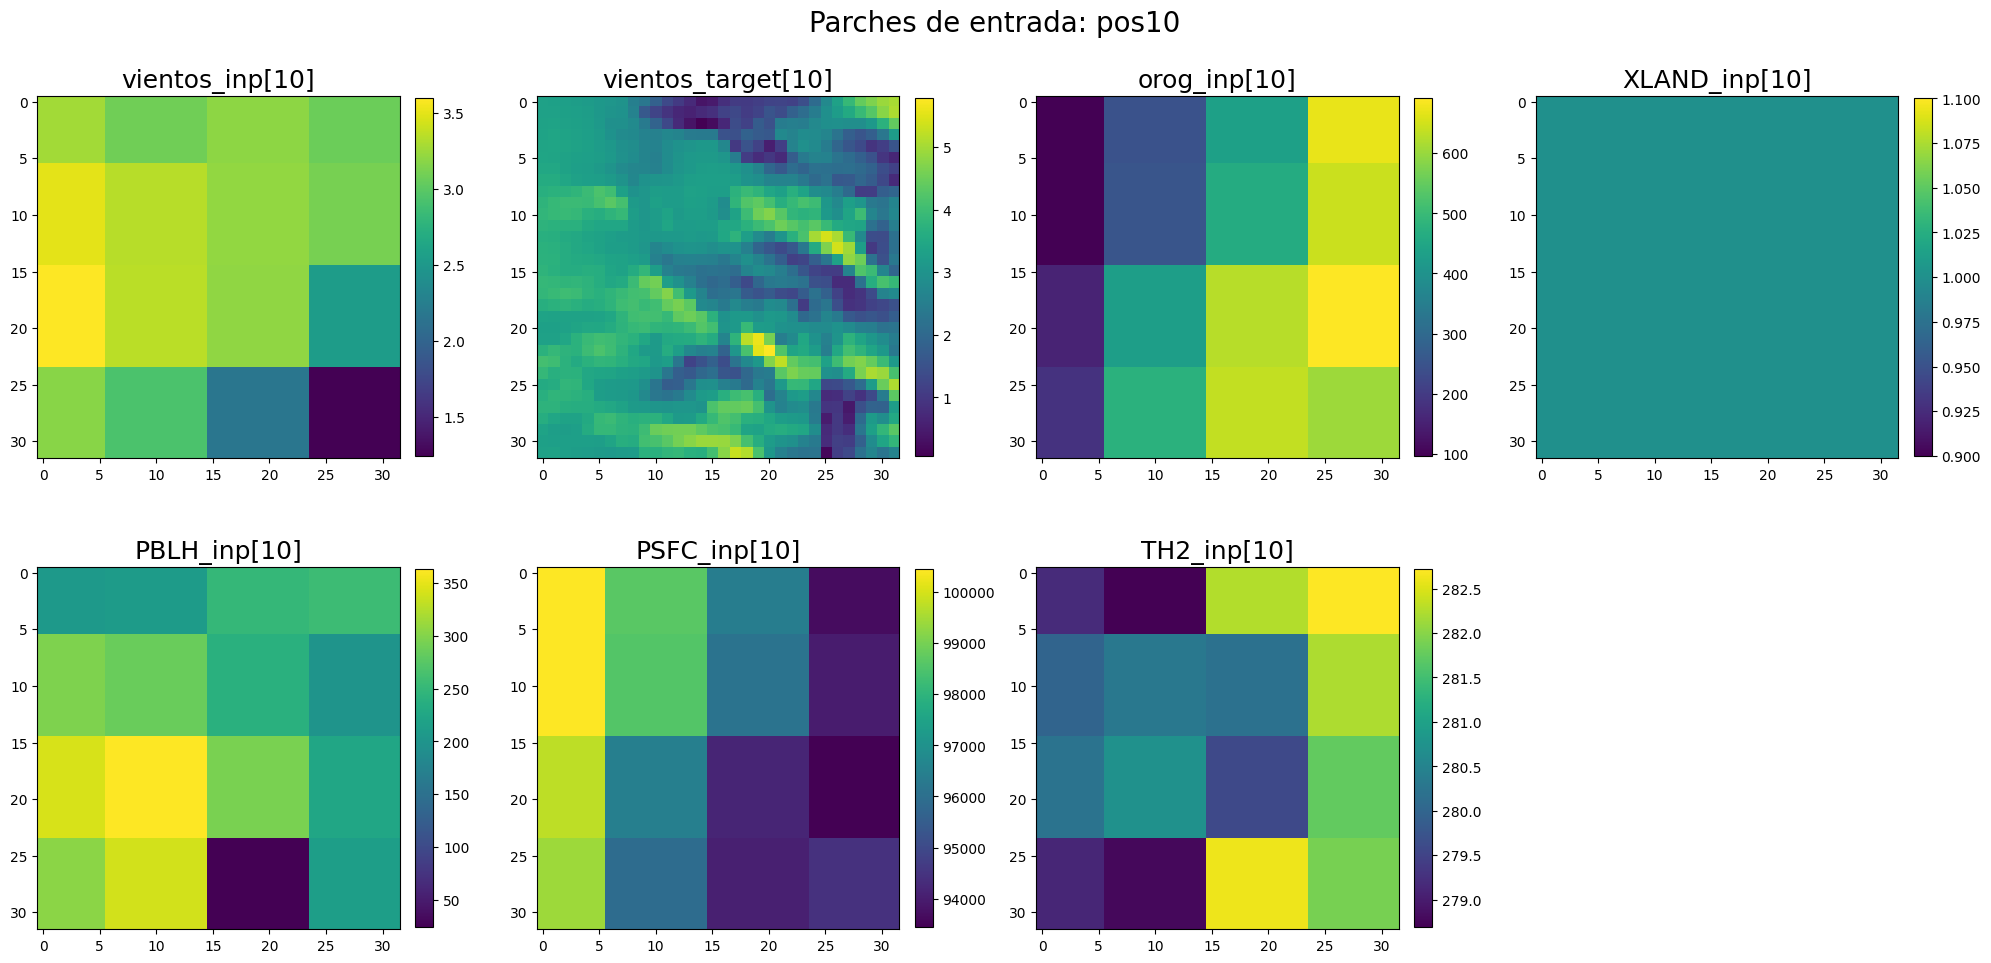

In [50]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np


idx=10
data =      [ vientos_input, vientos_target, orog_input, xland_input,  pblh_input, psfc_input,  th2_input]
nombres_var=["vientos_inp", "vientos_target", "orog_inp", "XLAND_inp", "PBLH_inp", "PSFC_inp", "TH2_inp"]

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 4, figure=fig)
fig.suptitle(f'Parches de entrada: pos{idx}', fontsize=20)
axes = [fig.add_subplot(gs[0, i]) for i in range(4)]
axes += [fig.add_subplot(gs[1, i]) for i in range(3)]

for i, ax in enumerate(axes):
    im = ax.imshow(tf.squeeze(data[i][idx]), cmap='viridis')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, shrink=0.8)
    ax.set_title(f'{nombres_var[i]}[{idx}]', fontsize=18)
    im.set_clim( np.min(tf.squeeze(data[i][idx])), np.max(tf.squeeze(data[i][idx])))

plt.tight_layout() 
plt.show()


In [51]:
%%time

stack_time= tf.zeros([1, 32, 32, 1]) #inicializamos un stack con las dimensiones requeridas

for caso in casos:
    for i in range(119): 
        tiempo=  tf.fill([32, 32], stack[variables[-1]][caso][i].astype(np.float32) ) #llenamos un parche (32,32) con el registro temporal
        tiempo= tf.reshape(tiempo, [1, 32, 32, 1]) #expandimos a las nuevas dimensiones requeridas
        tiempo=  tf.repeat(tiempo, 156, axis=0) # repetivos 156 veces el parche temporal creado
        stack_time=tf.concat( [stack_time, tiempo], axis=0) #concatenamos los parches creados para cada registro temporal

time2=stack_time[1:] #eliminamos el primer valor creado para inicializar el stack_time
print("Dimensiones tiempo: ",time2.shape)

Dimensiones tiempo:  (185640, 32, 32, 1)
CPU times: user 57.5 s, sys: 3min 55s, total: 4min 53s
Wall time: 48.8 s


##### [opc] Guardado de variables

In [16]:
#| code-fold: true
def guardado_parches(parches, nombre_parches, carpeta, opcional='', verbose=False):
    ruta_completa = os.path.join(carpeta, nombre_parches + opcional + '.npy')
    np.save(ruta_completa, parches)
    if verbose:
        print("Parches guardados exitosamente como: ", ruta_completa)

In [19]:
import os

ruta_guardado="../parches/080624_10/raw"

if not os.path.exists(ruta_guardado):
    
    os.makedirs(ruta_guardado)

    guardado_parches(vientos_target, "vientos_target_raw", ruta_guardado, "_08_06_24")
    guardado_parches(vientos_input,  "vientos_input_raw",  ruta_guardado, "_08_06_24")
    guardado_parches(orog_input,     "orog_input_raw",     ruta_guardado, "_08_06_24")
    guardado_parches(xlat_input,     "xlat_input_raw",     ruta_guardado, "_08_06_24")
    guardado_parches(xlong_input,    "xlong_input_raw",    ruta_guardado, "_08_06_24")
    guardado_parches(xland_input,    "xland_input_raw",    ruta_guardado, "_08_06_24")
    guardado_parches(pblh_input,     "pblh_input_raw",     ruta_guardado, "_08_06_24")
    guardado_parches(psfc_input,     "psfc_input_raw",     ruta_guardado, "_08_06_24")
    guardado_parches(th2_input,      "th2_input_raw",      ruta_guardado, "_08_06_24")
    guardado_parches(time2,          "time2_raw",          ruta_guardado, "_08_06_24")
                
    print("Parches guardados correctamente")
                
else:

    print("Ya existen variables guardadas en esa carpeta")


Parches guardados correctamente


#### Data split

In [1]:
from datasplit import Data_split
import numpy as np 


parches=np.zeros((156*119*10, 32, 32))

division_te           = Data_split(parches=parches, seed=20)
division_te.init_etiquetas()

intervalo_temporal_te = division_te.intervalo_temporal(porc_intervalo=0.04, verbose=True)
idx_random_te         = division_te.muestra_temporal(porc_muestra=0.08, verbose=True)
tiempos_extraer_te    = division_te.extraccion_temporal(verbose=True)
idx_cuadrantes_te     = division_te.muestra_espacial(verbose=True)
idx_mantener_te       = division_te.extraccion_espacial(verbose=True)
treino_te, testeo     = division_te.extraccion_final(porc_muestra=0.05, verbose=True)

 185640 etiquetas espaciales y temporales creadas correctamente
Proceso 1: Extracción intervalo temporal
Cantidad de tiempos extraidos:  47
Cantidad de tiempos restantes:  1143
------------------------------------------------------------
Proceso 2: Extracción muestra temporal
Cantidad de tiempos extraidos:  95
Cantidad de tiempos restantes:  1048
------------------------------------------------------------
Proceso 3: Exclusión de parches dado etiquetado temporal
Cantidad de tiempos extraídos totales:  142
Cantidad de parches original:  185640
Cantidad de parches extraídos:  22152
Cantidad de parches restantes:  163488
------------------------------------------------------------
Proceso 4: Extracción de cuadrantes
Cantidad de cuadrantes extraidos:  7
Cantidad de cuadrantes restantes:  149
------------------------------------------------------------
Proceso 5: Exclusión de parches dado etiquetado cuadrante.
Cantidad de parches extraídos:  8330
Cantidad de parches posterior extracción esp

In [2]:
division_va           =Data_split(parches=parches,indices=treino_te, seed=20)
division_va.init_etiquetas()
intervalo_temporal_va = division_va.intervalo_temporal(porc_intervalo=0.04, indices= tiempos_extraer_te, verbose=True )
idx_random_va         = division_va.muestra_temporal(porc_muestra=0.08, verbose=True)
tiempos_extraer_va    = division_va.extraccion_temporal(verbose=True)
idx_cuadrantes_va     = division_va.muestra_espacial(indices=idx_cuadrantes_te, verbose=True)
idx_mantener_va       = division_va.extraccion_espacial(verbose=True)
treino, validacion    = division_va.extraccion_final( porc_muestra=0.08, verbose=True)

 148344 etiquetas espaciales y temporales creadas correctamente
Proceso 1: Extracción intervalo temporal
Cantidad de tiempos extraidos:  47
Cantidad de tiempos restantes:  1001
------------------------------------------------------------
Proceso 2: Extracción muestra temporal
Cantidad de tiempos extraidos:  95
Cantidad de tiempos restantes:  906
------------------------------------------------------------
Proceso 3: Exclusión de parches dado etiquetado temporal
Cantidad de tiempos extraídos totales:  142
Cantidad de parches original:  148344
Cantidad de parches extraídos:  20144
Cantidad de parches restantes:  128200
------------------------------------------------------------
Proceso 4: Extracción de cuadrantes
Cantidad de cuadrantes extraidos:  7
Cantidad de cuadrantes restantes:  142
------------------------------------------------------------
Proceso 5: Exclusión de parches dado etiquetado cuadrante.
Cantidad de parches extraídos:  6950
Cantidad de parches posterior extracción espa

##### [opc] Guardado índices:

In [29]:
import pickle

ruta_guardado="../parches/080624_10/indices"
indices_file="indices_split_s20.pickle" #semilla usada: 20 

if not os.path.exists(ruta_guardado): 
    os.makedirs(ruta_guardado)
    print(f"carpeta {ruta_guardado} creada")

if not os.path.isfile(ruta_guardado + "/" + indices_file):
    indices_split={"treino": treino, "validacion": validacion, "testeo": testeo}
    with open(indices_file, 'wb') as file: 
        pickle.dump(indices_split, file)

    print(f"Diccionario guardado localmente como {indices_file}")

Diccionario guardado localmente como indices_split_s20.pickle


##### [opc] Revisión Independencia Conjuntos

In [33]:
set_entrenamiento= set(treino)
set_testeo       = set(testeo)
set_validacion   = set(validacion)

suma_conjuntos= len(treino) + len(validacion) + len(testeo)

if suma_conjuntos == time2.shape[0]:
    print("No existen elementos repetidos")
else: 
    print("Los conjuntos no están bien separados")

No existen elementos repetidos


#### Filtración Parches

In [35]:
def filtraciones_parches( var, treino=treino, testeo=testeo, validacion=validacion):

    tr = tf.gather(var, treino)
    va = tf.gather(var, validacion)
    te = tf.gather(var, testeo)

    return tr, va, te

target_tr, target_va, target_te = filtraciones_parches( vientos_target)
input_tr , input_va , input_te  = filtraciones_parches( vientos_input)
orog_tr  , orog_va  , orog_te   = filtraciones_parches( orog_input)
lat_tr   , lat_va   , lat_te    = filtraciones_parches( xlat_input)
lon_tr   , lon_va   , lon_te    = filtraciones_parches( xlong_input)
xland_tr , xland_va , xland_te  = filtraciones_parches( xland_input) 
pblh_tr  , pblh_va  , pblh_te   = filtraciones_parches( pblh_input) 
psfc_tr  , psfc_va  , psfc_te   = filtraciones_parches( psfc_input) 
th2_tr   , th2_va   , th2_te    = filtraciones_parches( th2_input) 
time_tr  , time_va , time_te    = filtraciones_parches( time2) 


print(f"Shape target_tr {target_tr.shape}, target_va: {target_va.shape}, target_te: {target_te.shape}" )

Shape target_tr (112423, 32, 32, 1), target_va: (35921, 32, 32, 1), target_te: (37296, 32, 32, 1)


#### Normalización de los parches

Normalizaremos CADA VARIABLE del conjunto de entrenamiento en el rango $[0,1]$ utilizando la siguiente fórmula:
$$ \text{normalización(variable)} := \dfrac{variable - \min(variable_{tr})}{\max(variable_{tr}) - \min(variable_{tr})}= \text{variable norm}$$
donde $\min(variable_{tr})$ y $\max(variable_{tr})$ corresponderán al mínimo y máximo valor de nuestra variable del conjunto de entrenamiento a normalizar respectivamente y serán guardados como factores de escalado para el resto de variables y para la posterior desnormalización.

In [37]:
def normalizacion( data_in,factores_escala=None,inversa=False):

    '''Método que normaliza los valores entregados.
    input:
        data_in: [tensor] Tensor con los parches de la variable que forma parte del input de la Red
        inverse: [Boolean, default=False] True en caso de devolver la transformación
    return: 
        variable normalizada
    '''

    data_tr = data_in[0]

    if not factores_escala:              
            factor_min  = tf.reduce_min(data_tr)
            factor_max  = tf.reduce_max(data_tr)

            factores_escala=[factor_min, factor_max ]
    
    data_new=[]

    for var in data_in:

        if not inversa:
            data_out= (var - factores_escala[0]) / (factores_escala[1] - factores_escala[0])

        else:
            data_out=(var * (factores_escala[1]- factores_escala[0]))+factores_escala[0]

        data_new.append(data_out)
    
    return data_new[0], data_new[1], data_new[2], factores_escala

In [ ]:
target_tr, target_va, target_te = filtraciones_parches( vientos_target)
input_tr , input_va , input_te  = filtraciones_parches( vientos_input)
orog_tr  , orog_va  , orog_te   = filtraciones_parches( orog_input)
lat_tr   , lat_va   , lat_te    = filtraciones_parches( xlat_input)
lon_tr   , lon_va   , lon_te    = filtraciones_parches( xlong_input)
xland_tr , xland_va , xland_te  = filtraciones_parches( xland_input) 
pblh_tr  , pblh_va  , pblh_te   = filtraciones_parches( pblh_input) 
psfc_tr  , psfc_va  , psfc_te   = filtraciones_parches( psfc_input) 
th2_tr   , th2_va   , th2_te    = filtraciones_parches( th2_input) 
time_tr  , time_va , time_te    = filtraciones_parches( time2) 

In [52]:
target_tr_norm, target_va_norm, target_te_norm, fact_target_tr = normalizacion([target_tr, target_va, target_te])
input_tr_norm , input_va_norm , input_te_norm , fact_input_tr  = normalizacion([input_tr , input_va , input_te])
orog_tr_norm  , orog_va_norm  , orog_te_nor   , fact_orog_tr   = normalizacion([orog_tr  , orog_va  , orog_te])
lat_tr_norm   , lat_va_norm   , lat_te_norm   , fact_lat_tr    = normalizacion([lat_tr   , lat_va   , lat_te])
lon_tr_norm   , lon_va_norm   , lon_te_norm   , fact_lon_tr    = normalizacion([lon_tr   , lon_va   , lon_te])
xland_tr_norm , xland_va_norm , xland_te_norm , fact_xland_tr  = normalizacion([xland_tr , xland_va , xland_te])
pblh_tr_norm  , pblh_va_norm  , pblh_te_norm  , fact_pblh_tr   = normalizacion([pblh_tr  , pblh_va  , pblh_te])
psfc_tr_norm  , psfc_va_norm  , psfc_te_norm  , fact_psfc_tr   = normalizacion([psfc_tr  , psfc_va  , psfc_te])
th2_tr_norm   , th2_va_norm   , th2_te_norm   , fact_th2_tr    = normalizacion([th2_tr   , th2_va   , th2_te])
time_tr_norm  , time_va_norm  , time_te_norm  , fact_time_tr   = normalizacion([time_tr  , time_va  , time_te])

In [61]:
def guardado_parches(variables, nombre, carpeta, opcional='', verbose=False):
    nombres_var=[nombre+"_tr_norm", nombre+"_va_norm", nombre+"_te_norm", nombre+"_tr_factor"]


    for var,nombre in zip(variables,nombres_var):
        ruta_completa = os.path.join(carpeta, nombre + opcional + '.npy')
        np.save(ruta_completa, var)
        if verbose:
            print("Parches guardados exitosamente como: ", ruta_completa)

In [65]:
ruta_guardado="../parches/080624_10/split"

if not os.path.exists(ruta_guardado):

    os.makedirs(ruta_guardado)
    guardado_parches(variables=[target_tr_norm, target_va_norm, target_te_norm, fact_target_tr], 
                     nombre="target", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[input_tr_norm, input_va_norm, input_te_norm, fact_input_tr], 
                     nombre="input", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[orog_tr_norm  , orog_va_norm  , orog_te_nor   , fact_orog_tr], 
                     nombre="orog", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[lat_tr_norm   , lat_va_norm   , lat_te_norm   , fact_lat_tr ], 
                     nombre="lat", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[lon_tr_norm   , lon_va_norm   , lon_te_norm   , fact_lon_tr ], 
                     nombre="lon", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[xland_tr_norm , xland_va_norm , xland_te_norm , fact_xland_tr], 
                     nombre="xland", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[pblh_tr_norm  , pblh_va_norm  , pblh_te_norm  , fact_pblh_tr], 
                     nombre="pblh", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[psfc_tr_norm  , psfc_va_norm  , psfc_te_norm  , fact_psfc_tr], 
                     nombre="psfc", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[th2_tr_norm   , th2_va_norm   , th2_te_norm   , fact_th2_tr], 
                     nombre="th2", carpeta=ruta_guardado, opcional='_080624_10')
    guardado_parches(variables=[time_tr_norm  , time_va_norm  , time_te_norm  , fact_time_tr], 
                     nombre="time", carpeta=ruta_guardado, opcional='_080624_10')

In [4]:
from collections import Counter 

def calcular_frecuencias(idx_contar, etiquetas_cuad= division_te.etiquetas_cuadrantes): 

    cuadrantes= [ int(etiquetas_cuad[idx][1][0]) for idx in idx_contar]
    counter_cuad= Counter(cuadrantes)
    freq_cuadrantes= list(counter_cuad.items())

    idx_restantes= set( range(0,156,1)) - set( counter_cuad.keys())

    for cuad in idx_restantes:
        freq_cuadrantes.append( [cuad, 0])

    freq_cuadrantes=  sorted(freq_cuadrantes, key=lambda x: x[0])
    
    return freq_cuadrantes, counter_cuad

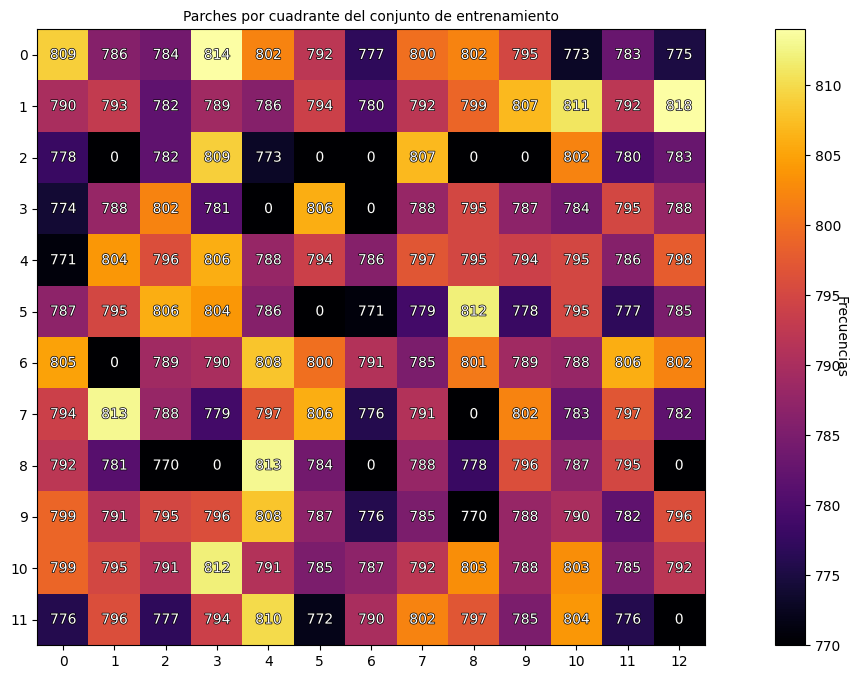

In [19]:
from funciones import grafico_espacial

freq_tr, counter_cuad_tr=  calcular_frecuencias(treino)
grafico_espacial(freq_tr, counter_cuad_tr, str_conjunto='entrenamiento', cmap='inferno')

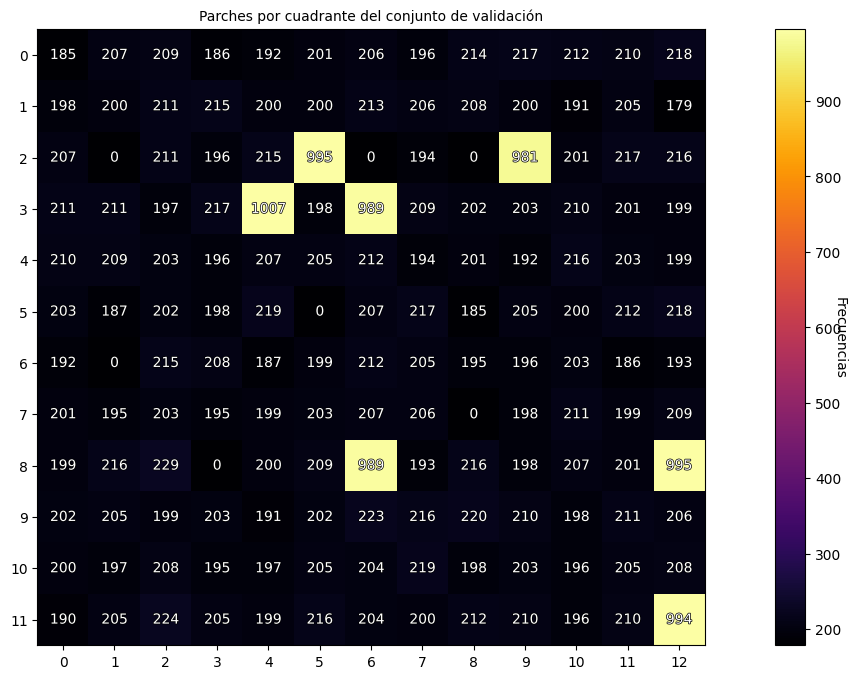

In [15]:
freq_va, counter_cuad_va=  calcular_frecuencias(validacion)
grafico_espacial(freq_va, counter_cuad_va, str_conjunto='validación', cmap='inferno')

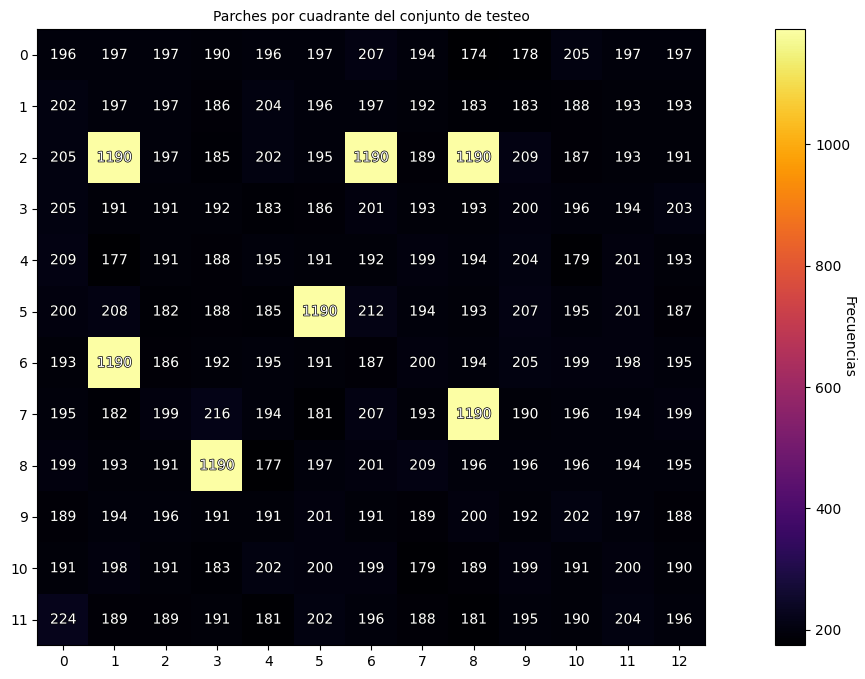

In [17]:
freq_te, counter_cuad_te=  calcular_frecuencias(testeo)
grafico_espacial(freq_te, counter_cuad_te, str_conjunto='testeo', cmap='inferno')